In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import mra 
import selector as se

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)
random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 10
eps_sublevel = percent = 0.1

num_agents = num_commodities = 100
history = 5
res_type="primal"

filename = "subgrad_mcf_N%d_%.2f_n%d_H%d_%s"%(num_points, eps_sublevel, num_agents, history, res_type)

In [4]:
num_vertices = 15
num_edges = 100

params, A_ineq, b_ineq = mra.mcf_data(num_vertices, num_edges, num_commodities)

In [5]:
b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [6]:
true_x, true_f, true_lamb = mra.centralized_multi_commodity_flow(params, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=-127.24864071521705


In [7]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

0.9999999999761228

In [8]:
true_lamb.shape, true_x.shape

((100, 1), (10000, 1))

In [9]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.mcf_query_multiple_actions(lamb_k, i, params[i], 
                                                                           eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.mcf_query_multiple_actions_noisy_prices(lamb_k, i, params[i], percent=percent, K=K)]

fun_obj_val = lambda x_k: mra.mcf_obj_value(x_k, params)

# Dual subgradient

In [10]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()

K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

### Best learning schedule

In [11]:
alpha_ks = ["0.1/sqrt(k)", "1/sqrt(k)", "1/k", "10/k"]
func_alphas = {"0.1/sqrt(k)": lambda k: 0.1 / np.sqrt(k+1), 
               "1/sqrt(k)": lambda k: 1 / np.sqrt(k+1),
               "1/k": lambda k: 1 / (k+1),
               "10/k": lambda k: 10 / (k+1)}

best_schedule = [np.inf, "0.1/sqrt(k)"] 

for alpha_k, func_alpha_k in func_alphas.items():
    print(f"{alpha_k=}")
    all_results = mra.dual_proj_subgradient(fun_agents_eps, fun_obj_val, primal_var_size,
                                                             func_alpha_k, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=1, num_iters=20, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type=res_type, history=1)[0]

    if all_results["viol_primal_paver_xk"][-1] < best_schedule[0]:
        best_schedule = [all_results["viol_primal_paver_xk"][-1], alpha_k]

alpha_k='0.1/sqrt(k)'


/Users/tepars/anaconda3/envs/py311/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)
/Users/tepars/anaconda3/envs/py311/lib/python3.11/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/tepars/Documents/postdoc/mra_precovery/mra

epoch=0, f_subopt_xk=7.2274E-01,  f_subopt_mra=7.2274E-01,  viol_xk=3.3057E+02, viol_mra=3.3057E+02, lamb_rel_diff=INF
epoch=19, f_subopt_xk=3.0342E-01,  f_subopt_mra=3.0342E-01,  viol_xk=3.6225E+02, viol_mra=3.6225E+02, lamb_rel_diff=2.8446E-02
alpha_k='1/sqrt(k)'
epoch=0, f_subopt_xk=7.2274E-01,  f_subopt_mra=7.2274E-01,  viol_xk=3.3057E+02, viol_mra=3.3057E+02, lamb_rel_diff=INF
epoch=19, f_subopt_xk=2.1695E-01,  f_subopt_mra=2.1695E-01,  viol_xk=9.9772E+02, viol_mra=9.9772E+02, lamb_rel_diff=5.3274E-01
alpha_k='1/k'
epoch=0, f_subopt_xk=7.2274E-01,  f_subopt_mra=7.2274E-01,  viol_xk=3.3057E+02, viol_mra=3.3057E+02, lamb_rel_diff=INF
epoch=19, f_subopt_xk=1.3941E-01,  f_subopt_mra=1.3941E-01,  viol_xk=1.4712E+02, viol_mra=1.4712E+02, lamb_rel_diff=5.2346E-02
alpha_k='10/k'
epoch=0, f_subopt_xk=7.2274E-01,  f_subopt_mra=7.2274E-01,  viol_xk=3.3057E+02, viol_mra=3.3057E+02, lamb_rel_diff=INF
epoch=19, f_subopt_xk=3.7163E-01,  f_subopt_mra=3.7163E-01,  viol_xk=1.3100E+03, viol_mra=1.31

In [12]:
best_alpha_k = best_schedule[1]
print(f"{best_alpha_k=}")
func_alpha_k = func_alphas[best_alpha_k]

best_alpha_k='0.1/sqrt(k)'


In [13]:
all_results_eps, lamb_k_eps, _, x_k, _, mra_xk_eps  = mra.dual_proj_subgradient(fun_agents_eps, fun_obj_val, primal_var_size, func_alpha_k, 
                                                                                             A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type=res_type, history=history)


all_results_noisy_y, lamb_k_eps, _, x_k, _, mra_xk_noisy_y  = mra.dual_proj_subgradient(fun_agents_noisy_y, fun_obj_val, primal_var_size, func_alpha_k, 
                                                                                             A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type=res_type, history=history)

epoch=0, f_subopt_xk=7.2274E-01,  f_subopt_mra=6.9194E-01,  viol_xk=3.3057E+02, viol_mra=3.2561E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=9.7400E-02,  f_subopt_mra=2.4832E-01,  viol_xk=3.2387E+02, viol_mra=3.2827E+01, lamb_rel_diff=1.5136E-02
epoch=100, f_subopt_xk=3.2825E-02,  f_subopt_mra=1.4776E-01,  viol_xk=8.6775E+01, viol_mra=1.5347E+01, lamb_rel_diff=1.6748E-02
epoch=149, f_subopt_xk=2.2023E-02,  f_subopt_mra=1.1150E-01,  viol_xk=5.6087E+01, viol_mra=1.0285E+01, lamb_rel_diff=1.2280E-02
epoch=0, f_subopt_xk=7.2274E-01,  f_subopt_mra=7.1771E-01,  viol_xk=3.3057E+02, viol_mra=3.2991E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=9.7400E-02,  f_subopt_mra=2.4475E-01,  viol_xk=3.2387E+02, viol_mra=3.4874E+01, lamb_rel_diff=1.5136E-02
epoch=100, f_subopt_xk=3.2825E-02,  f_subopt_mra=1.2137E-01,  viol_xk=8.6775E+01, viol_mra=1.4882E+01, lamb_rel_diff=1.6748E-02
epoch=149, f_subopt_xk=2.2023E-02,  f_subopt_mra=8.1064E-02,  viol_xk=5.6087E+01, viol_mra=9.8859E+00, lamb_rel_diff=1.2280E

In [14]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

T=150
0.022022616359462892 sub_eps 0.11149721477419822 noisy_y 0.08106423411514235 proj 0.4245854337448712


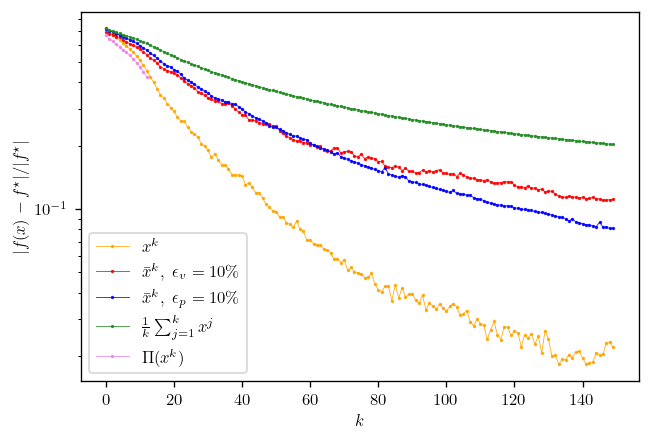

In [15]:
mra.plot_func_subopt_all(all_res, all_results_eps, all_results_noisy_y, true_f, eps_sublevel, percent, 
                        filename=filename)

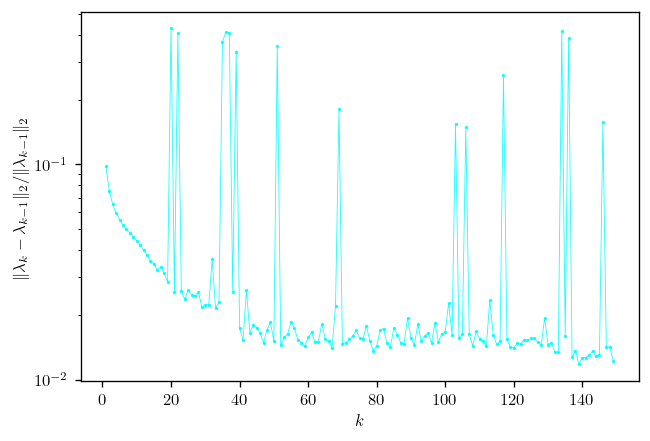

In [16]:
mra.plot_lamb_k_diff(all_res, filename)

In [17]:
print(np.array(all_res["viol_primal_xk"])[-1],
      "sub_eps", np.array(all_results_eps["viol_primal_mra_xk"])[-1],
      "noisy_y", np.array(all_results_noisy_y["viol_primal_mra_xk"])[-1])

18.279757284141528 sub_eps 0.0 noisy_y 0.0


In [18]:
print("sub_eps", np.array(all_results_eps["viol_primal_mra_xk"]).size,
      "noisy_y", np.array(all_results_noisy_y["viol_primal_mra_xk"]).size)

sub_eps 150 noisy_y 150


T=150
0.9334648736749267 sub_eps 0.0 noisy_y 0.0


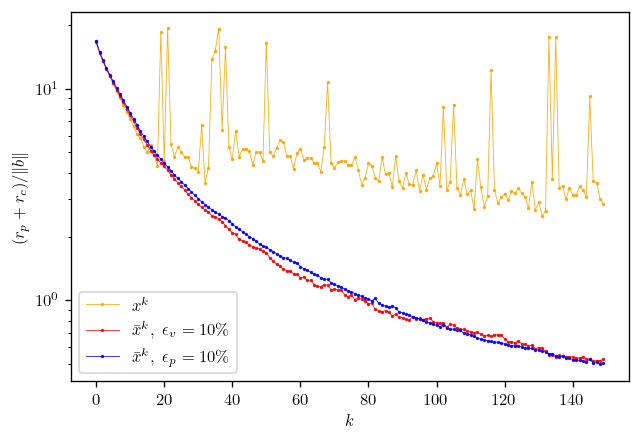

In [19]:
mra.plot_prim_complem_residuals(all_res, all_results_eps, all_results_noisy_y, b_norm, eps_sublevel, percent, 
                               filename=filename)

T=150
0.9334648736749267 sub_eps 0.0 noisy_y 0.0


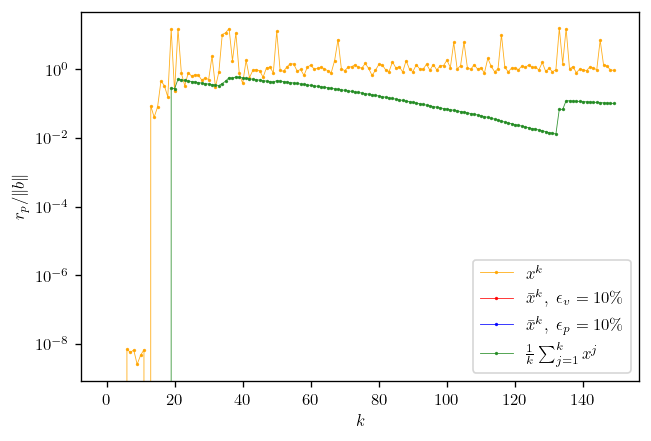

In [20]:
mra.plot_prim_residuals(all_res, all_results_eps, all_results_noisy_y, b_norm, eps_sublevel, percent, 
                       filename=filename)

T=150


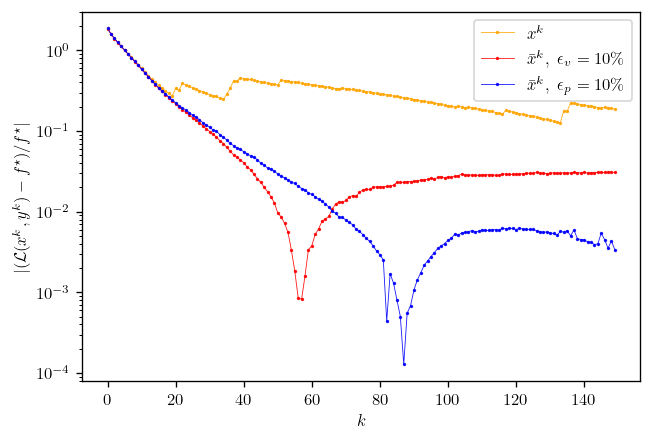

In [21]:
mra.plot_lagr_subopt_all(all_res, all_results_eps, all_results_noisy_y, eps_sublevel, percent, true_f=true_f,
                        filename=filename)

In [22]:
T = 150
idx_xk = np.argmin(np.array(all_res["viol_primal_xk"])[:T])
idx_paverage = np.argmin(np.array(all_res["viol_primal_paver_xk"])[:T])
idx_noisy_y = np.where(np.array(all_results_noisy_y["viol_primal_mra_xk"][:T]) < 1e-8)[0][0]
idx_eps = np.where(np.array(all_results_eps["viol_primal_mra_xk"][:T]) < 1e-8)[0][0]

print(f"{idx_xk=}, {idx_eps=}, {idx_noisy_y=}, {idx_paverage=}")

print("xk", (np.abs(np.array(all_res["f_xk"]) - true_f)/np.abs(true_f))[idx_xk],
    "sub_eps", (np.abs(np.array(all_results_eps["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_eps],
    "noisy_y", (np.abs(np.array(all_results_noisy_y["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_noisy_y],
    "proj", ((np.abs(np.array(all_res["f_proj_xk"]) - true_f))/np.abs(true_f)).min(),
    "paverage", (np.abs(np.array(all_res["f_paver_xk"]) - true_f)/np.abs(true_f))[idx_paverage])

print("xk", np.array(all_res["viol_primal_xk"])[idx_xk],
      "sub_eps", all_results_eps["viol_primal_mra_xk"][idx_eps],
      "noisy_y", all_results_noisy_y["viol_primal_mra_xk"][idx_noisy_y],
      "paverage", np.array(all_res["viol_primal_paver_xk"])[idx_paverage])

idx_xk=0, idx_eps=0, idx_noisy_y=0, idx_paverage=0
xk 0.722736576531258 sub_eps 0.6919356929840063 noisy_y 0.7177055244804786 proj 0.4245854337448712 paverage 0.722736576531258
xk 0.0 sub_eps 0.0 noisy_y 0.0 paverage 0.0


In [23]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
# res["eps"].keys()

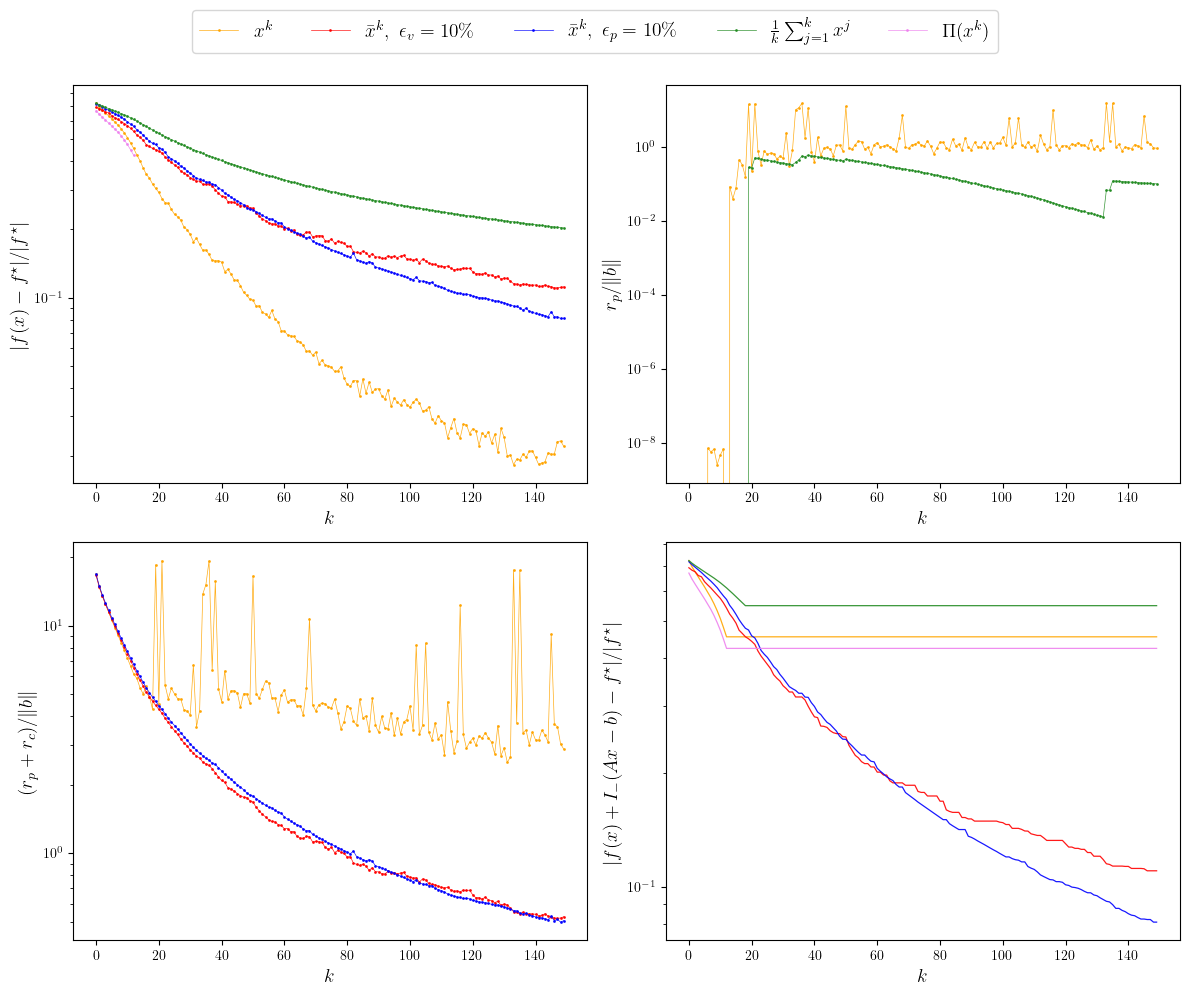

In [24]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, filename, T)